# Homework 3: Hypothesis Testing & Regression

Jake Dame

7 Jun 2024

CS 6017: Data Analytics & Visualization

Dr. Ben Jones

In [614]:
# Set-up

from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm

from datetime import datetime, timezone
import time

# Part 1: Data Acquisition



In [615]:
# Get robots.txt file using HTTP GET request
response = requests.get("https://news.ycombinator.com/robots.txt")

# Convert response object to string and print
print(response.text)

User-Agent: *
Crawl-delay: 30
Disallow: /collapse?
Disallow: /context?
Disallow: /flag?
Disallow: /login
Disallow: /logout
Disallow: /r?
Disallow: /reply?
Disallow: /submitlink?
Disallow: /vote?
Disallow: /x?



The `robots.txt` indicates that the rules apply to all web crawlers, and shows various files and file-paths that crawlers are disallowed access. The crawl rate is 1 request per 30 seconds.

In [616]:
def get_first_n_pages(n):
    
    base_url = "https://news.ycombinator.com/news?p="
    html_str = ""

    for page_num in range(1, n+1):

        page_num = str(page_num)

        # get raw html file as string
        response = requests.get(base_url + page_num)

        # concatenate each page's content
        html_str += response.text

        # if you try and do this without some kind of sleeping, you will end up 
        #   with only 4 pages worth of data, because between the 4th and 5th pages
        #   there is probably some kind of captcha or crawler-mitigation thing
        # this isn't a '1 request per 30 seconds' rate, but it does the trick
        time.sleep(1)

    # use python parser to make bs4 object
    soup = BeautifulSoup(html_str, 'html.parser')

    return soup

In [617]:
# This is a helper function to parse the time and process it into what we need
#   https://stackoverflow.com/questions/15940280/how-to-get-utc-time-in-python

def decimal_hours(age_attr):

    posted_time = datetime.fromisoformat(age_attr)
    if posted_time.tzinfo is None:
        posted_time = posted_time.replace(tzinfo = timezone.utc)
    
    now = datetime.now(timezone.utc)
    age = now - posted_time
    hours = age.total_seconds() / 3600

    return hours

In [618]:
# Get a BeautifulSoup object
n = 5
soup = get_first_n_pages(n)

# Get all the 'athings' (HackerNews's tag for stories) from the html text
athings = soup.find_all('tr', class_='athing')

# Empty list to store a bunch of story data
stories_data = []

# For every Tag object 'athing' in the ResultSet 'athings'
for athing in athings:

    # rank
    rank_tag = athing.find(class_='rank')
    rank = rank_tag.text.strip('.') 

    # title
    title_tag = athing.find(class_='titleline').find('a')
    title = title_tag.text

    # score, age, and comments are in another (i.e. the next) table row; per story

    subtext_tag = athing.find_next_sibling('tr')

    # points/score
    score_tag = subtext_tag.find(class_ = 'score')
    score = score_tag.text.split()[0] if score_tag else 0

    # age in hours
    age_tag = subtext_tag.find(class_ = 'age')
    age_attr = age_tag.get('title') 
    age = decimal_hours(age_attr)

    # number of comments
    #   the comments element is in the last anchor tag in each subtext
    comments_tag = subtext_tag.find_all('a')[-1]
    comments = 0
    if comments_tag.text == 'discuss' or comments_tag.text == 'hide':
        pass
    else:
        comments = comments_tag.text.split()[0]
    
    # Make a dictionary and add it to stores_data list each iteration
    #   Rank is stored inversely, which can be easier in the data analysis stuff
    stories_data.append( {'Rank': 151 - int(rank),
                          'TitleLength':len(title),
                          'Age':age,
                          'Score':int(score),
                          'Comments':int(comments)} )

In [619]:
# Convert list of dictionaries to df
df = pd.DataFrame(stories_data)

# Convert df to csv file
df.to_csv('stories_data.csv', index=False)

df

,Rank,TitleLength,Age,Score,Comments
0,150,56,6.103124,209,111
1,149,40,59.067291,147,65
2,148,18,13.212846,365,58
3,147,14,8.663402,154,18
4,146,49,9.011457,125,43
...,...,...,...,...,...
145,5,62,51.955904,887,372
146,4,48,35.906738,118,100
147,3,62,30.766182,58,44
148,2,77,53.678960,33,6


# Part 2: Regression



In [620]:
# Convert data in csv file to df
df = pd.read_csv('stories_data.csv')

# Display some basic information about the data
display( df.describe() )
display( df.head() )
display( df.dtypes )

,Rank,TitleLength,Age,Score,Comments
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,51.106667,23.690690,107.580000,55.326667
std,43.445368,18.838468,16.317948,149.514663,99.504578
min,1.000000,9.000000,0.649513,0.000000,0.000000
25%,38.250000,36.250000,10.485763,15.000000,2.000000
50%,75.500000,53.000000,17.284653,47.500000,15.500000
75%,112.750000,66.000000,36.737987,140.750000,62.750000
max,150.000000,83.000000,60.718680,887.000000,836.000000


,Rank,TitleLength,Age,Score,Comments
0,150,56,6.103124,209,111
1,149,40,59.067291,147,65
2,148,18,13.212846,365,58
3,147,14,8.663402,154,18
4,146,49,9.011457,125,43


Rank             int64
TitleLength      int64
Age            float64
Score            int64
Comments         int64
dtype: object

In [621]:
model_1 = sm.ols( formula='Rank ~ Age', data=df ).fit()

model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     20.17
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           1.42e-05
Time:                        00:22:46   Log-Likelihood:                -768.48
No. Observations:                 150   AIC:                             1541.
Df Residuals:                     148   BIC:                             1547.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     97.3427      5.900     16.500      0.000      85.684     109.001
Age           -0.9220      0.205     -4.491      0.000      -1.328      -0.516
==============================================================================
Omnibus:                        5.969   Durbin-Watson:                   0.232
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                3.485
Skew:                           0.167   Prob(JB):                        0.175
Kurtosis:                       2.332   Cond. No.                         50.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 1 Overview:

Model 1 tested only the relationship between Age and Rank. This could model what would "happen" to a story Rank-wise if it didn't have any other sort of engagement like votes or comments.

- R-squared of 0.160 indicates that Age alone is not really a big predictor of Rank, as it only explains 16% of the variation in Rank.
- Intercept says that for being a brand new story, you can expect a rank of around 97
- Age coefficient of -1.1207 means that for every unit of change in Age, Rank decreases ≈1 unit, which makes sense -- Age alone, with no other explantory variables that would measure engagement, would mean this story would just sort of fall away over time
- P-value of ≈0 means that Age is most likely a statistically significant predictor of Rank

In [622]:
model_2 = sm.ols( formula='Rank ~ Comments + Score + Age', data=df ).fit()

model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     7.564
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           9.74e-05
Time:                        00:22:46   Log-Likelihood:                -767.23
No. Observations:                 150   AIC:                             1542.
Df Residuals:                     146   BIC:                             1555.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     96.3268      5.932     16.238      0.000      84.602     108.051
Comments      -0.0653      0.062     -1.057      0.292      -0.187       0.057
Score          0.0645      0.042      1.530      0.128      -0.019       0.148
Age           -1.0195      0.221     -4.622      0.000      -1.455      -0.584
==============================================================================
Omnibus:                        4.251   Durbin-Watson:                   0.271
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                2.974
Skew:                           0.186   Prob(JB):                        0.226
Kurtosis:                       2.419   Cond. No.                         377.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 2 Overview:

Model 2 added in engagement-type independent variables (Comments and Score) to Age, to try and model how we could predict Rank based on engagement levels (using Comments and Score as metrics), over time.

However, there was not really much of an increase in R-squared, meaning either the model is bad, the data is bad, the analysis is bad (or not appropriate for this data), or that there are yet more variables that better explain the variation in Rank.

- R-squared of 0.172 indicate that Age, Comments, and Score alone are not a big predictor of Rank. They only explain about 17% of the variation in Rank.
- Intercept says that for being a brand new story, with 0 comments, and 0 points, you can expect a rank of around 97.
- Age coefficient is similar to first model.
- Score coefficient of 0.0505 indicates that there is about a .05 increase in Rank for each increase in Score, all other variables constant
  - P-value of 0.188 indicates Score alone is not likely a statistically significant predictor of Rank
- Comments coefficient of 0.0505 indicates that there is about a .05 decrease in Rank for each increase in Comments, all other variables constant
  - P-value of 0.424 indicates Comments alone is definitely not a statistically significant predictor of Rank

In [623]:
# model 3

model_3 = sm.ols( formula='Rank ~ Comments + Score + Age + TitleLength', data=df ).fit()

model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     7.286
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           2.25e-05
Time:                        00:22:46   Log-Likelihood:                -764.33
No. Observations:                 150   AIC:                             1539.
Df Residuals:                     145   BIC:                             1554.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     118.5346     10.969     10.806      0.000      96.854     140.215
Comments       -0.0428      0.062     -0.696      0.488      -0.164       0.079
Score           0.0481      0.042      1.145      0.254      -0.035       0.131
Age            -1.0205      0.217     -4.701      0.000      -1.450      -0.591
TitleLength    -0.4240      0.177     -2.391      0.018      -0.774      -0.074
==============================================================================
Omnibus:                        2.662   Durbin-Watson:                   0.338
Prob(Omnibus):                  0.264   Jarque-Bera (JB):                2.262
Skew:                           0.187   Prob(JB):                        0.323
Kurtosis:                       2.529   Cond. No.                         714.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 3 Overview

There is not much more to add interpretation-wise to Model 3. The numbers are mostly similar. 

- R-squared only increased by about .02, bringing it to .19, meaning that even with every data point/independent variable available to us, something is missing from the model in explaining the variation in Rank.
- TitleLength has a coefficient of -0.3542, meaning that the longer the title, there is a slight negative correlation with Rank
	- P-value of 0.042 indicates that TitleLength is a statistically-significant predictor of Rank

## Regression Summary

**"Compare/contrast them."**

See above.

**"Which is the most useful."**

None of them are particularly "useful", except for the one that only included Age, to show that Rank does have some negative correlation with Age.

**"Are there linear relationships between any of the variables?"**

Just the one mentioned above.

TitleLength has a slight negative correlation with Rank.

**"How about other relationships like inverse linear (1/x)?"**

See above.

# Part 3: Classification



In [624]:
# Create a categorical variable --> FRONT PAGE (1) or NOT FRONT PAGE (0)

f = lambda rank: 1 if rank >= 121 else 0

df['FrontPage'] = df['Rank'].apply(f)

df

,Rank,TitleLength,Age,Score,Comments,FrontPage
0,150,56,6.103124,209,111,1
1,149,40,59.067291,147,65,1
2,148,18,13.212846,365,58,1
3,147,14,8.663402,154,18,1
4,146,49,9.011457,125,43,1
...,...,...,...,...,...,...
145,5,62,51.955904,887,372,0
146,4,48,35.906738,118,100,0
147,3,62,30.766182,58,44,0
148,2,77,53.678960,33,6,0


Optimization terminated successfully.
         Current function value: 0.491803
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              FrontPage   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Sat, 08 Jun 2024   Pseudo R-squ.:                 0.01719
Time:                        00:22:46   Log-Likelihood:                -73.770
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                    0.1082
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9089      0.354     -2.566      0.010      -1.603      -0.215
Age           -0.0217      0.

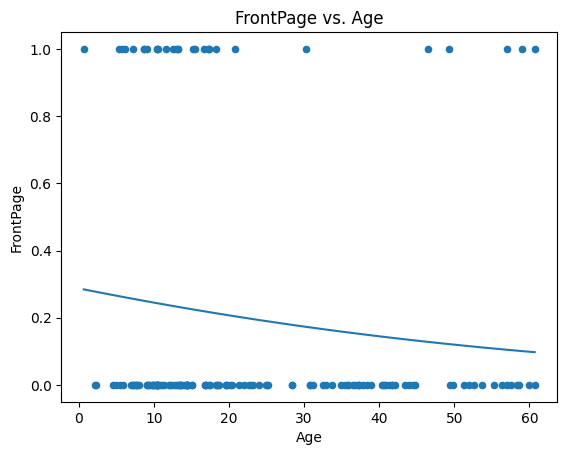

In [625]:
# 1st model

# Variable to be able to try various single-variable models
var = 'Age'

logistic_model_1 = sm.logit( formula='FrontPage ~ ' + var, data=df ).fit()

print(logistic_model_1.summary())

# Define logistic(x) function
logistic = lambda _: 1 / ( 1 + np.exp(-_) )

# Plot actual data points
df.plot.scatter( x=var, y='FrontPage')

# Overlay with line
params = dict(logistic_model_1.params)

# Get beta values from logit function model
beta_0 = params['Intercept']
beta_1 = params[var]

x = np.linspace( df[var].min(), df[var].max() )

# Plot logistic regression curve --> y = logistic(OLS model)
y = logistic( beta_0  + beta_1 * x ) 

plt.plot(x, y)

plt.xlabel(var)
plt.ylabel('FrontPage')
plt.title('FrontPage vs. ' + var)

plt.show()

## Logistic Model 1: Overview

- We can see a minority of (assuming around 30) data points that have actual $y$-values of 1, because they were actually on the front page
- The logistic regression line represents the likelihood of a story (what each data point represents) being on the front page based on its age in hours.
- The $y$-intercept represents the probability of a brand new story being on the front page
- The older a story is, the less likely it is to be on the front page

Optimization terminated successfully.
         Current function value: 0.470324
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              FrontPage   No. Observations:                  150
Model:                          Logit   Df Residuals:                      145
Method:                           MLE   Df Model:                            4
Date:                Sat, 08 Jun 2024   Pseudo R-squ.:                 0.06011
Time:                        00:22:46   Log-Likelihood:                -70.549
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                   0.06051
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0747      0.668     -0.112      0.911      -1.384       1.235
Age            -0.0309    

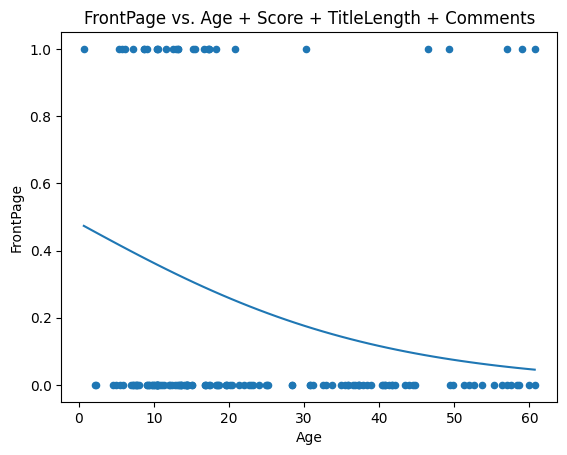

In [626]:
# 2nd model

logistic_model_2 = sm.logit( formula='FrontPage ~ Age + Score + TitleLength + Comments', data=df ).fit()

print(logistic_model_2.summary())

# Define logistic(x) function
logistic = lambda _: 1 / ( 1 + np.exp(-_) )

# Plot actual data points
df.plot.scatter( x='Age', y='FrontPage')

# Overlay with line
params = dict(logistic_model_2.params)
print(params)
beta_0 = params['Intercept']
beta_1 = params[var]

x = np.linspace( df['Age'].min(), df['Age'].max() )

y = logistic( beta_0  + params['Age'] * x + params['Score'] * x + params['TitleLength'] * x + params['Comments'] * x )

plt.plot(x, y)

plt.xlabel(var)
plt.ylabel('FrontPage')
plt.title('FrontPage vs. Age + Score + TitleLength + Comments')

plt.show()

## Logistic Model 2: Overview

This model, with all predictor variables at our disposal, still does not fully explain the variation in the model.

## Classification Summary

**"What do your regressions tell you about making the front page?"**

That it is more complicated than just how old the story is, how many comments it gets, its score, and the length of its title.

- The P-values of all of my models were too high for anything to be statistically significant
- The coefficients weren't strong enough to indiciate any kind of strong correlation